# Importando dependências

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
# coletando dados
dados = pd.read_csv('Viz_alura_voz.csv')
dados.head()

,Churn,gênero,idoso,Parceiro,Dependentes,Meses contrato,Serviço telefone,Linhas multiplas,Serviço Internet,Segurança Online,...,Dispositivo_Proteção,Suporte Técnico,Tv Streaming,Filmes Streaming,Contrato,Conta Papel,Método pagamento,Cobrança Mensal,Cobrança Total,Cobrança diária
0,Não,Mulher,Não,Sim,Sim,9,Sim,Não,DSL,Não,...,Não,Sim,Sim,Não,Um ano,Sim,Correspondência,65.6,593.30,2.186667
1,Não,Homem,Não,Não,Não,9,Sim,Sim,DSL,Não,...,Não,Não,Não,Sim,Mês a mês,Não,Correspondência,59.9,542.40,1.996667
2,Sim,Homem,Não,Não,Não,4,Sim,Não,Fibra óptica,Não,...,Sim,Não,Não,Não,Mês a mês,Sim,Eletrônico,73.9,280.85,2.463333
3,Sim,Homem,Sim,Sim,Não,13,Sim,Não,Fibra óptica,Não,...,Sim,Não,Sim,Sim,Mês a mês,Sim,Eletrônico,98.0,1237.85,3.266667
4,Sim,Mulher,Sim,Sim,Não,3,Sim,Não,Fibra óptica,Não,...,Não,Sim,Sim,Não,Mês a mês,Sim,Correspondência,83.9,267.40,2.796667


In [10]:
# Separando dados para pré-processamento
## dados
X = dados.iloc[:,1:]
y = dados.iloc[:,0]

## Balanceamento de dados

In [11]:
print("Desbalanceamento dos dados: {:.2f}%".format(dados.Churn.value_counts()[1]/dados.Churn.value_counts()[0]*100))

Desbalanceamento dos dados: 36.20%


---

* Segundo Google Developers, **20-40%** de dados desbalanceados é considerado um desbalanceamento **suave**. 

Obs: fonte :https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

---

In [14]:
# definindo oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
X_over.shape, y_over.shape

((10326, 20), (10326,))

In [20]:
# definindo one hot encoding para as variáveis X
encoder = OneHotEncoder(sparse=False)

# transformando dados
X_enc = encoder.fit_transform(X_over.select_dtypes('object'))

# definindo label encoder para variável y 
le = LabelEncoder()

# transformando dados
le.fit(y_over)
y_enc = le.transform(y_over)

In [25]:
# Feature Selection (Redução de dimensionalidade)
fs = SelectKBest(score_func=f_classif, k=5)

# aplicando redução de dimensionalidade
X_selected = fs.fit_transform(X_enc, y_enc)
print(X_selected.shape)

(10326, 5)


In [28]:
# Separando dados em Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_enc, test_size=0.33, random_state=1)

In [29]:
# formato do dataset
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6918, 5), (6918,), (3408, 5), (3408,))

### Baseline

In [32]:
# Classificador de base
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [33]:
# Y previsto pelo classificador base
y_pred = dummy_clf.predict(X_test)

In [38]:
# Taxa de acerto do classificador 
print('A taxa de acerto do baseline é : {:.2f}%'.format(dummy_clf.score(X_test, y_test)*100))

A taxa de acerto do baseline é : 49.50%


In [41]:
# Matrix de confusão para analisar as decisões do algoritmo 
confusion_matrix(y_test, y_pred)

array([[   0, 1721],
       [   0, 1687]], dtype=int64)

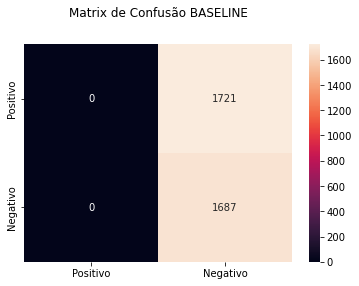

In [45]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d")
ax.set(xticklabels=['Positivo', 'Negativo'], yticklabels=['Positivo', 'Negativo'])
ax.set_title("Matrix de Confusão BASELINE", y=1.1);
plt.gcf().set_size_inches(10, 6)

---

* Pelo matrix de confusão pode-se perceber que o algoritmo clássificou todos os dados de uma única maneira e alcancou **49,50%** de acerto com 1687 dados negativos verdadeiros e 1721 falsos positivos.

---

## Regressão Logística

In [54]:
# definindo modelos e parâmetros
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2']

c_values = [100, 10, 1.0, 0.1, 0.01]
#  grid search

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result1 = grid_search.fit(X_train, y_train)
# resumo

print("Melhor: %f parâmetros %s" % (grid_result1.best_score_, grid_result1.best_params_))
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']

Melhor: 0.742410 parâmetros {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


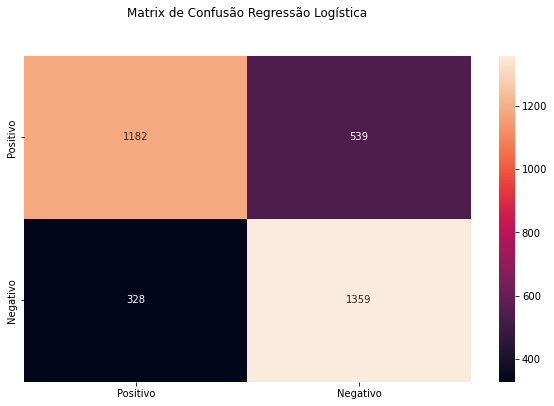

In [61]:
# Gerando matrix de confusão
y_hat = grid_result1.predict(X_test)
ax = sns.heatmap(confusion_matrix(y_test, y_hat),annot=True, fmt="d")
ax.set(xticklabels=['Positivo', 'Negativo'], yticklabels=['Positivo', 'Negativo'])
ax.set_title("Matrix de Confusão Regressão Logística", y=1.1);
plt.gcf().set_size_inches(10, 6)

---

* Analisando a matrix de confusão do algoritmo de **Regressão Logística**, chegamos a conclusão que foram 1230 positivos verdadeiros e 491 de falsos positivos, 357 falsos negativos e 1330 verdadeiros negativos. Pontuando **74,69%** de acuracidade.

---

## Árvore de Classificação

In [64]:
# definindo modelos e parâmetros
model = BaggingClassifier()
n_estimators = [10, 100, 1000]

# grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result2 = grid_search.fit(X_train, y_train)

# Resumo
print("Melhor: %f parâmetros %s" (grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']

Best: 0.744963 using {'n_estimators': 10}


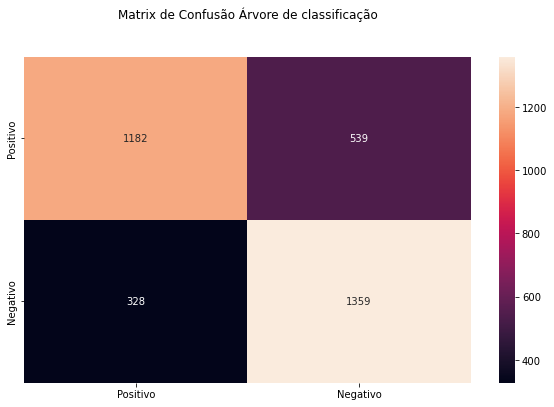

In [66]:
# matrix de confusão
grid_result2.score(X_test, y_test)
confusion_matrix(y_test, y_hat)
ax = sns.heatmap(confusion_matrix(y_test, y_hat),annot=True, fmt="d")
ax.set(xticklabels=['Positivo', 'Negativo'], yticklabels=['Positivo', 'Negativo'])
ax.set_title("Matrix de Confusão Árvore de classificação", y=1.1);
plt.gcf().set_size_inches(10, 6)

---

* Como podemos ver, o modelo de Árvore de Classificação não apresentou diferenças do modelo anterior.

---

### Resumo

In [94]:
print('A pontuação dos classificadores foram:\nBaseline: {:.2f}\nRegressão Logística: {:.2f}\nÁrvore de Classificação: {:.2f}'.format(dummy_clf.score(X_test, y_test)*100, grid_result1.best_score_*100, grid_result2.best_score_*100))

A pontuação dos classificadores foram:
Baseline: 49.50
Regressão Logística: 74.24
Árvore de Classificação: 74.50


* Em resumo o melhor classificador pode alcançar até **74,50% de acurácia na previsão dos dados.**